In [1]:
import scanpy as sc
# import episcanpy as epi
import pandas as pd
import numpy as np
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import KernelDensity

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

def npy2df(input_file, return_gene_info=False):
    """
    Load the npy file with X number of bursting parameter estimation for a given gene. 
    if return_gene_info is True : 
        return the df containing the estimation, the gene index number (starting from 1, not 0) and a gene array of some sort?
    else: return the dataframe with the parameter estimation as column and each estimation attemps as rows
        
    """
    gene_no, gene, result = np.load(input_file, allow_pickle='True')
    
    result_flatten = result.flatten()
    df = pd.DataFrame([x for x in result_flatten])
    
    if return_gene_info:
        return(df, gene_no, gene)
    else:
        return(df)
    
def BFandBS(df):
    """
    input is the dataframe containing the parameters as columns.
    need column named 'koff', 'roff', 'kon', 'ron' 
    
    compute burst frequency and burst size from the parameters
    """
    df['tau_off']= df['kon']/df['ron']
    df['tau_on'] = df['koff']/df['roff']
    df['bf'] = 1./(df['tau_on'] + df['tau_off'])
    df['bs'] = df['mu'] * df['tau_on']

def best_parameters(df, density_kernel_name=None, save_kde="density_kernel", test=[]):
    """
    return the index for the best parameters.
    
    if density_kernel_name is None , we recompute the gaussian kde and if save_kde is a str. 
    Save the kde in df using save_kde as column name
    """
    
    if density_kernel_name is None:
        # Calculate the point density
        xy = np.vstack([df['bs'],df['bf']])
        
        adata = ad.read("./data/mus_musculus_preprocessed_all_params.h5ad")
        cast = adata.to_df(layer='allele_cast').transpose()
        
        s = test
        

        z = gaussian_kde(xy)(xy)

#         Vecvalues=np.concatenate((df['bs'], df['bf']))[:,None]
#         Vecpoints=np.linspace(np.min(s), np.max(s), 5000)[:,None]
#         kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(Vecvalues)
#         logkde = kde.score_samples(Vecpoints)

#         z = np.exp(logkde) 
    
        if save_kde is not False:
            df[save_kde] = z
            
    else:
        z = df[density_kernel_name]
    
    return(np.where(z == np.amax(z))[0][0])

import matplotlib.pyplot as plt

import seaborn as sns
sns.color_palette("viridis")

def plot_kde(df, bs, bf, kde="density_kernel",
             title=None, dot_size=4, colormap='viridis',
             best_param=True,
             linestype='-', color_line='grey',
             norm_scale=True,
             show=True,
             save=None):
    """
    

    --> put the line with best parameter as an option..
    
    --> later we need to create a wrapper function to give a adata objet + a gene name
    
    df
    bs
    df
    kde="density_kernel"
    title
    size
    colormap
    best_param
    linestype
    color_line
    norm_scale
    show
    save
    """
    
    # scatter plot
    if norm_scale:
        fig = sns.scatterplot(data=df, x=bf, y=bs,
                              hue=kde, size_norm=(0,1),
                              palette=colormap, s=dot_size)
    else:
        fig = sns.scatterplot(data=df, x=bf, y=bs,
                              hue=kde, hue_norm=(np.min(df['density_kernel']),
                                                 np.max(df['density_kernel'])),
                              palette=colormap, s=dot_size)
    
    if title is not None: 
        fig.set_title(title)
    
    #plt.legend(loc=legend_loc)
    plt.legend(bbox_to_anchor=(1.05, 1),
               loc='upper left',
               borderaxespad=0,
              title='kernel density')
    
    if best_param : 
    
        # Add the best parameter estimation based on the density kernel
        index_max_parameter = best_parameters(df, save_kde="density_kernel")
        xmax = df[bs][index_max_parameter]
        ymax = df[bf][index_max_parameter]
        fig.axvline(ymax, color="grey", linestyle="-.", linewidth=0.5) #linestyle or ls: {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}
        fig.axhline(xmax, color="grey", linestyle="-.", linewidth=0.5)
    
    
    # plot / saving settings
    if save is not None:
        plt.savefig(save, bbox_inches='tight')
    if show :
        plt.show()
        


In [3]:
import numpy as np
from scipy import stats
from numpy import mean
from numpy.random import beta, poisson
from scipy.special import j_roots
from scipy.special import beta as beta_fun
from matplotlib import pyplot as plt
import pandas as pd

def dBP(at, alpha, bet, lam):
    at.shape = (len(at),1)
    np.repeat(at, 50, axis = 1)
    def fun(at, m):
        if(max(m) < 1e6):
            return(stats.poisson.pmf(at,m))
        else:
            return(stats.norm.pdf(at,loc=m,scale=sqrt(m)))
    if alpha <= 0 or bet <= 0:
        return np.nan
    x,w = j_roots(50,alpha = bet-1, beta = alpha - 1)
    gs = np.sum(w*fun(at, m = lam*(1+x)/2), axis=1)
    prob = 1/beta_fun(alpha, bet)*2**(-alpha-bet+1)*gs
    return(prob)

# Load the data and extract Fos value

In [4]:
adata = ad.read("./data/mus_musculus_preprocessed_all_params.h5ad")
adata

AnnData object with n_obs × n_vars = 682 × 7439
    obs: 'plate', 'leiden', 'clusters', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'sum_allele_c57', 'sum_allele_cast', 'sum_ratio_allele_c57', 'sum_ratio_allele_cast', 'ratio_sum_allele_c57', 'ratio_sum_allele_cast', 'ratio_mean_allele_c57', 'ratio_mean_allele_cast', 'ratio_std_allele_c57', 'ratio_std_allele_cast', 'allele_p_value', 'gene_name', 'chromosome', 'autosomes', 'nuclear', 'Ribosomal_prot', 'gene_count_corr', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes', 'c57_kon', 'c57_koff', 'c57_ksyn', 'cast_kon', 'cast_koff', 'cast_ksyn', 'total_kon', 'tota

In [5]:
gene_name = "Fos"
index_fos = adata.var_names.tolist().index(gene_name)
gene_values = [x[0] for x in adata.X[:,index_fos].todense()]


# plot distribution of Fos

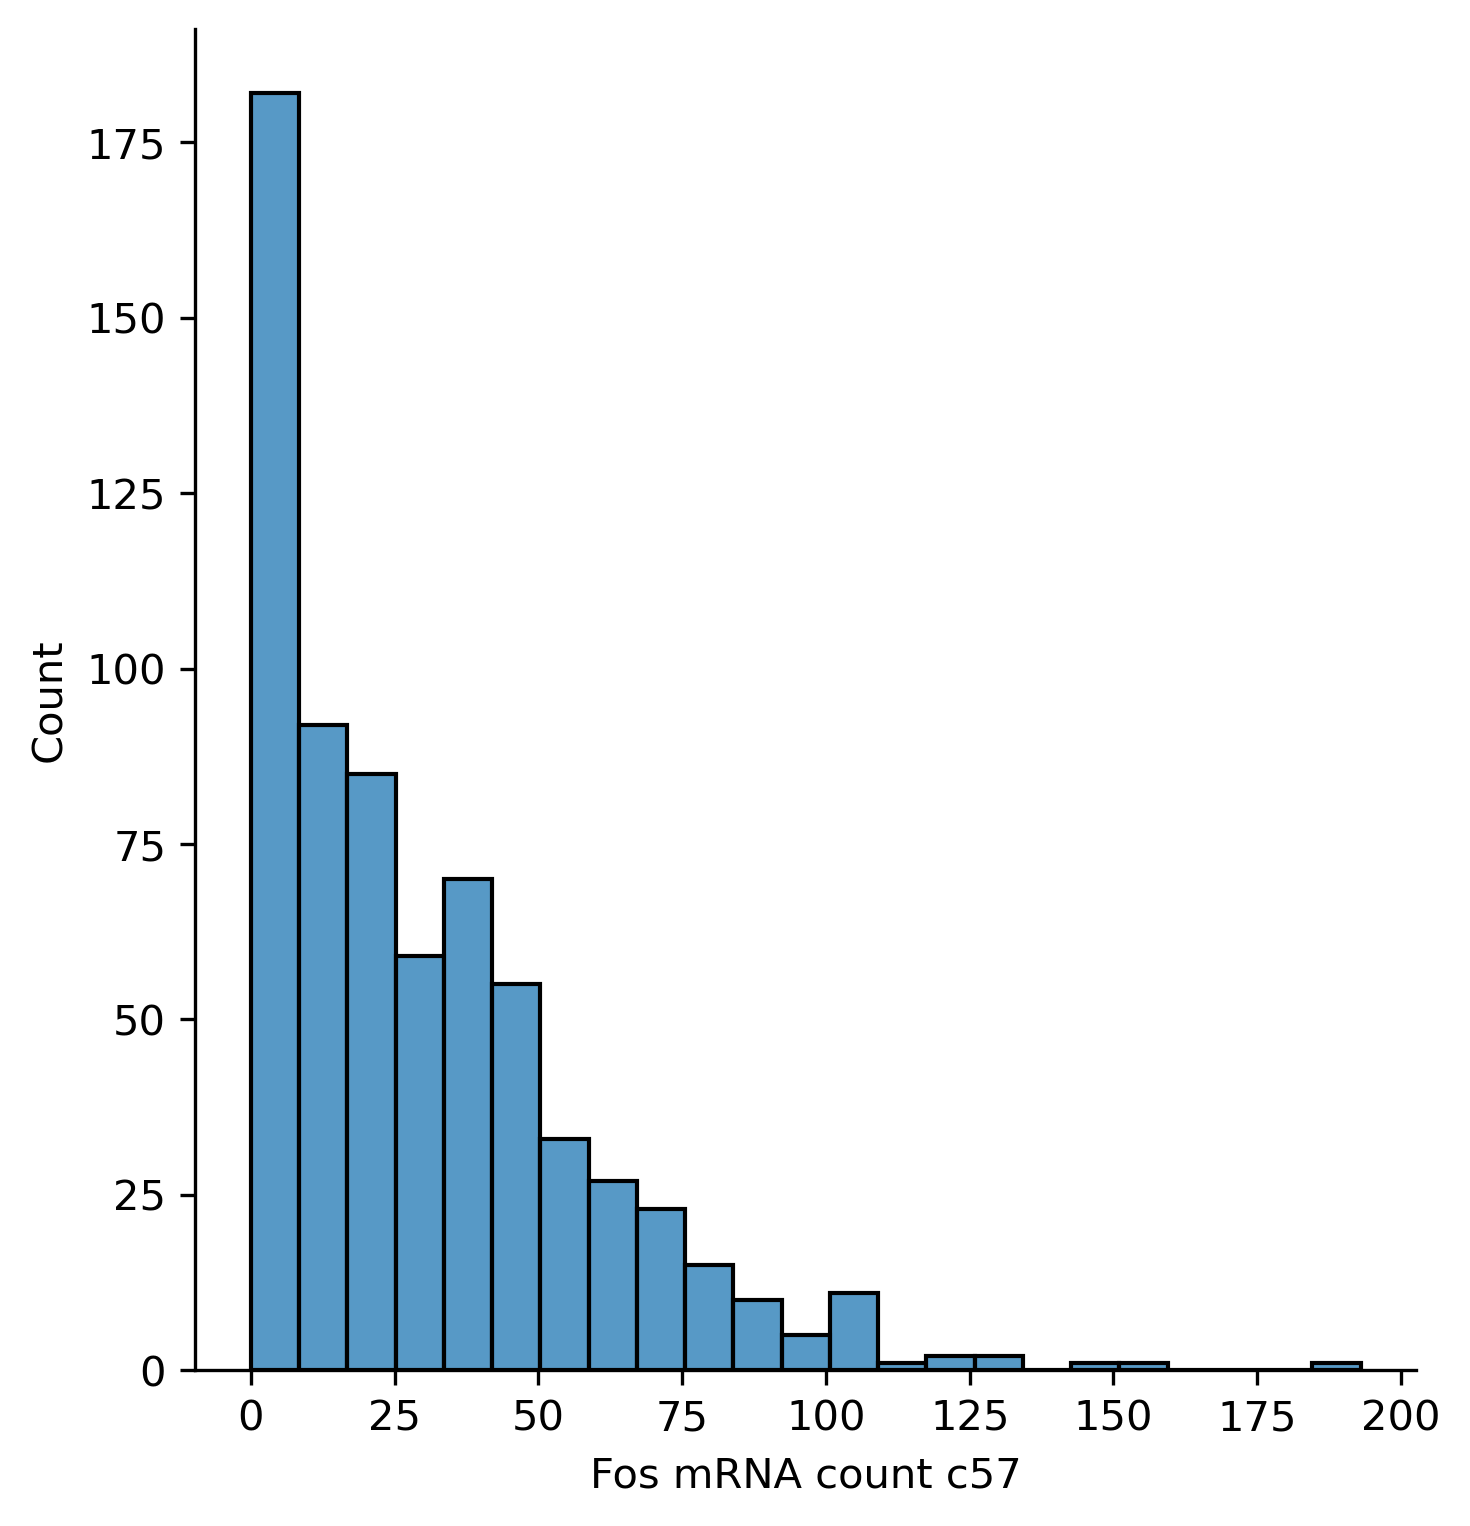

In [6]:
gene_name = "Fos"
allele = "allele_c57"
index_fos = adata.var_names.tolist().index(gene_name)
gene_values = adata.layers[allele][:,index_fos].tolist()

sns.displot(gene_values)
plt.xlabel("Fos mRNA count c57")
plt.show()

# Add ctm line

In [7]:
df_param_ctm = pd.read_csv("./../test/data/arme/umiSplit_c57.qc.maxl.ci.wfilt1.csv",
                      header=None,
                      index_col=0)
df_param_ctm

,1,2,3,4,5,6,7,8,9
0,,,,,,,,,
ENSMUSG00000000001,4.252039,26.865740,96.092819,2.702795,6.017169,2.210820,7.908801,100,100
ENSMUSG00000000028,0.137546,1.025523,16.144363,0.109138,0.212030,9.487846,20.515211,100,100
ENSMUSG00000000037,0.078290,0.999971,1.852708,0.034711,0.228232,0.531360,4.224191,100,100
ENSMUSG00000000058,0.779049,12.358448,37.516225,0.484199,0.961267,2.394180,6.576081,100,100
ENSMUSG00000000078,0.784579,2.727669,56.502058,0.681904,1.103465,12.028828,25.700570,100,100
...,...,...,...,...,...,...,...,...,...
ENSMUSG00000096699,0.055771,0.460551,6.009451,0.029863,0.129351,4.247061,26.079432,100,100
ENSMUSG00000097571,0.219019,16.302314,14.232093,0.117263,0.353373,0.479911,1.623884,100,100
ENSMUSG00000098466,0.127843,1.424644,1.000000,0.085092,0.548184,0.100207,0.771126,100,100


In [8]:
# extract kon, koff, ksyn for Fos
cells=682 # number of cells
gene_id = adata.var['Accession'][index_fos]
tot_kon,tot_koff, tot_ksyn = df_param_ctm.loc[gene_id][:3]
tot_koff



5.677569832420217

In [9]:
c57 = pd.read_csv('./../test/data/arme/umiSplit_c57.qc.csv', index_col=0)
gene_values = c57.loc[gene_id].tolist()

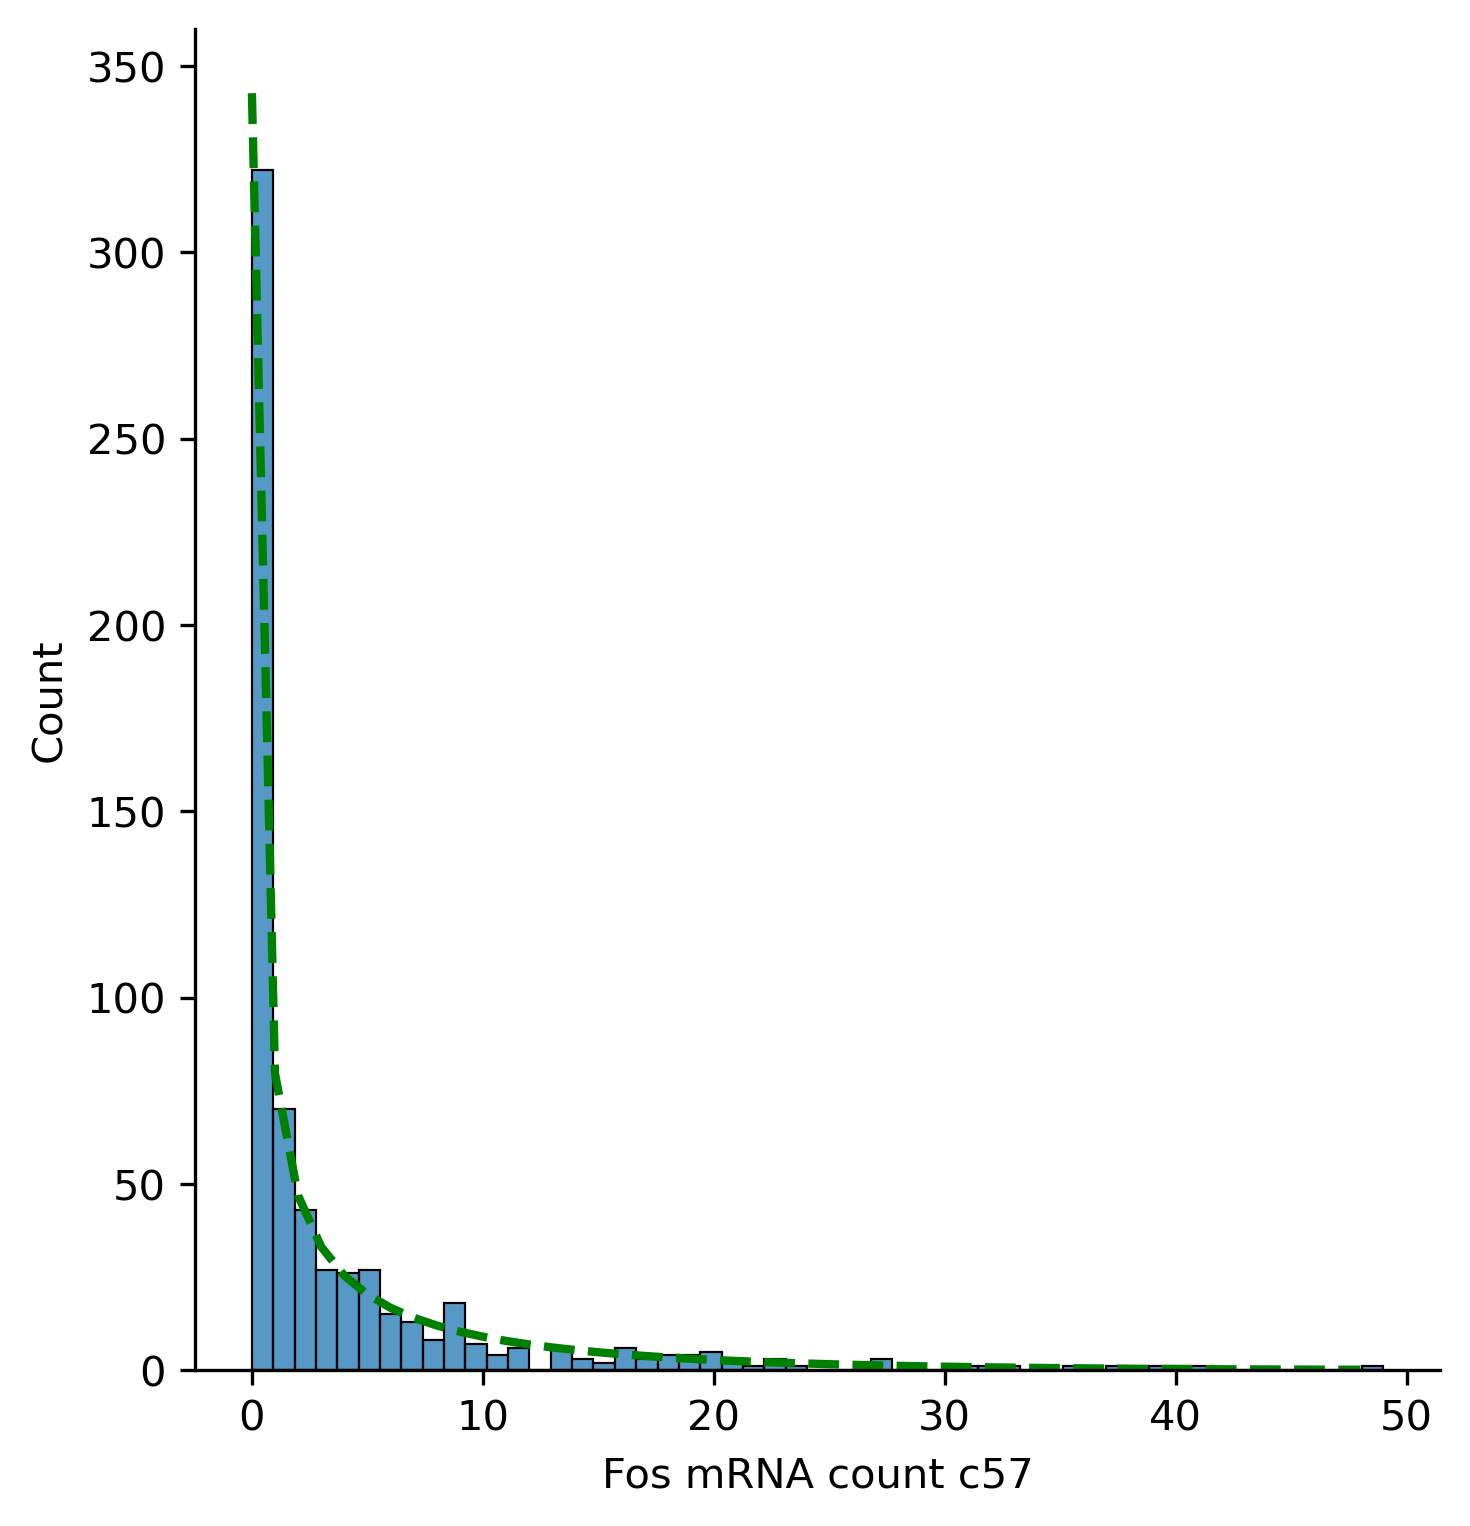

In [10]:
gene_name = "Fos"
allele = "allele_c57"
#index_fos = adata.var_names.tolist().index(gene_name)
#gene_values = adata.layers[allele][:,index_fos].tolist()

sns.displot(gene_values)


plt.plot(cells*dBP(np.arange(max(gene_values)), tot_kon, tot_koff, tot_ksyn),'g--',linewidth=2)

plt.xlabel("Fos mRNA count c57")
plt.show()

# Add GTM line

In [11]:
df_GTM = npy2df(input_file="./data/plot_gtm/gene_Fos_c57.npy")
BFandBS(df_GTM)
df_GTM

,kon,ron,koff,roff,mu,delta,dist,tau_off,tau_on,bf,bs
0,0.177634,0.274173,2.108189,7.225365,80.303911,1.0,0.076652,0.647890,0.291776,1.064208,23.430766
1,6.127418,5.203205,0.400687,0.704417,83.874562,1.0,0.252441,1.177624,0.568821,0.572592,47.709644
2,3.748272,1.182511,10.457457,6.567164,95.401035,1.0,0.322622,3.169755,1.592386,0.209990,151.915235
3,7.020078,2.043361,15.624613,8.591618,66.879193,1.0,0.268577,3.435555,1.818588,0.190326,121.625693
4,7.280038,1.864468,15.875188,7.867852,67.998497,1.0,0.239116,3.904619,2.017728,0.168852,137.202493
...,...,...,...,...,...,...,...,...,...,...,...
4995,3.804228,0.902766,2.138972,0.551978,55.485709,1.0,0.559850,4.213970,3.875107,0.123624,215.013037
4996,5.905861,2.637155,1.632033,1.604325,104.714272,1.0,0.352958,2.239482,1.017271,0.307054,106.522758
4997,7.519651,2.735737,1.568814,1.029543,60.264016,1.0,0.284098,2.748675,1.523797,0.234057,91.830123
4998,7.020078,2.043361,15.624613,8.591618,66.879193,1.0,0.268577,3.435555,1.818588,0.190326,121.625693


In [12]:
# gene_id = adata.var['Accession'][index_fos]
# index_param = best_parameters(df_GTM)
# tot_kon_gtm = df_GTM['ron'][index_param]
# tot_koff_gtm = df_GTM['roff'][index_param]
# tot_ksyn_gtm = df_GTM['mu'][index_param]

In [13]:
# gene_name = "Fos"
# allele = "allele_c57"

# sns.displot(gene_values)
# plt.xlabel("Fos mRNA count c57")

# plt.plot(cells*dBP(np.arange(max(gene_values)), tot_kon, tot_koff, tot_ksyn),'g--',linewidth=2)
# plt.plot(cells*dBP(np.arange(max(gene_values)), tot_kon_gtm, tot_koff_gtm, tot_ksyn_gtm),'r--',linewidth=2)


# plt.show()

# All in one : 

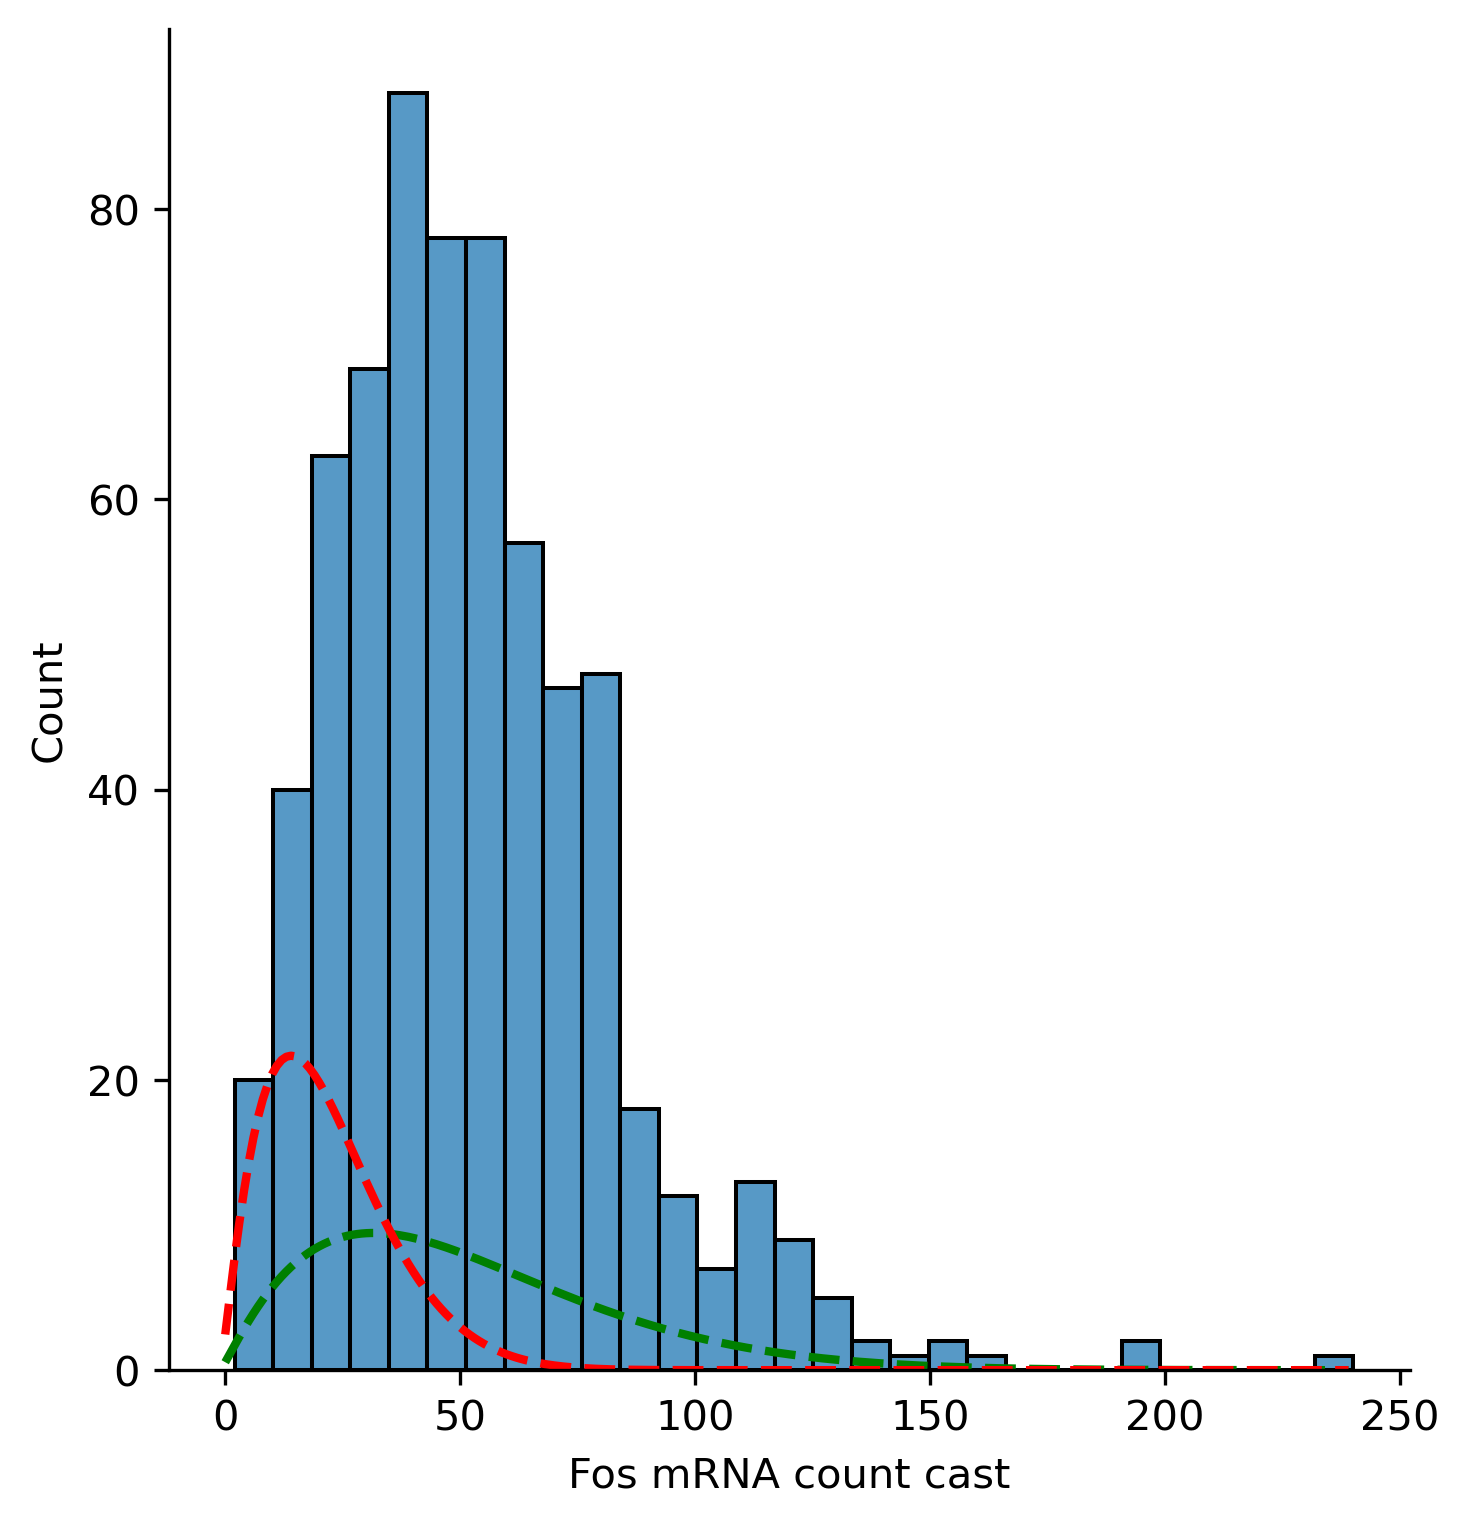

In [14]:
# cast fos
allele= 'cast'
gene_name = "Fos"
adata = ad.read("./data/mus_musculus_preprocessed_all_params.h5ad")
cast = adata.to_df(layer='allele_cast').transpose()
cast.index = adata.var.Accession

index_gene = adata.var_names.tolist().index(gene_name)
gene_id = adata.var['Accession'][index_gene]

################
# df_param_ctm = pd.read_csv("./../test/data/arme/umiSplit_cast.qc.maxl.ci.wfilt1.csv",
#                       header=None,
#                       index_col=0)
# extract kon, koff, ksyn for Fos
cells=682 # number of cells

tot_kon,tot_koff, tot_ksyn = tot_kon,tot_koff, tot_ksyn = adata.var.loc[gene_name]['cast_kon'], adata.var.loc[gene_name]['cast_koff'], adata.var.loc[gene_name]['cast_ksyn']
tot_koff

################
gene_values = np.array(cast.loc[gene_id])
gene_values = gene_values[gene_values>0]

df_GTM = npy2df(input_file="./data/plot_gtm/gene_Fos_cast.npy")
BFandBS(df_GTM)
index_param = best_parameters(df_GTM, test = gene_values)
tot_kon_gtm = df_GTM['ron'][index_param]
tot_koff_gtm = df_GTM['roff'][index_param]
tot_ksyn_gtm = df_GTM['mu'][index_param]

index_gene = adata.var_names.tolist().index(gene_name)
# gene_values = cast.loc[gene_id].tolist()



sns.displot(gene_values)
plt.plot(cells*dBP(np.arange(max(gene_values)), tot_kon, tot_koff, tot_ksyn),'g--',linewidth=2)
plt.plot(cells*dBP(np.arange(max(gene_values)), tot_kon_gtm, tot_koff_gtm, tot_ksyn_gtm),'r--',linewidth=2)
plt.xlabel("".join([gene_name, " mRNA count ", allele]))



plt.show()

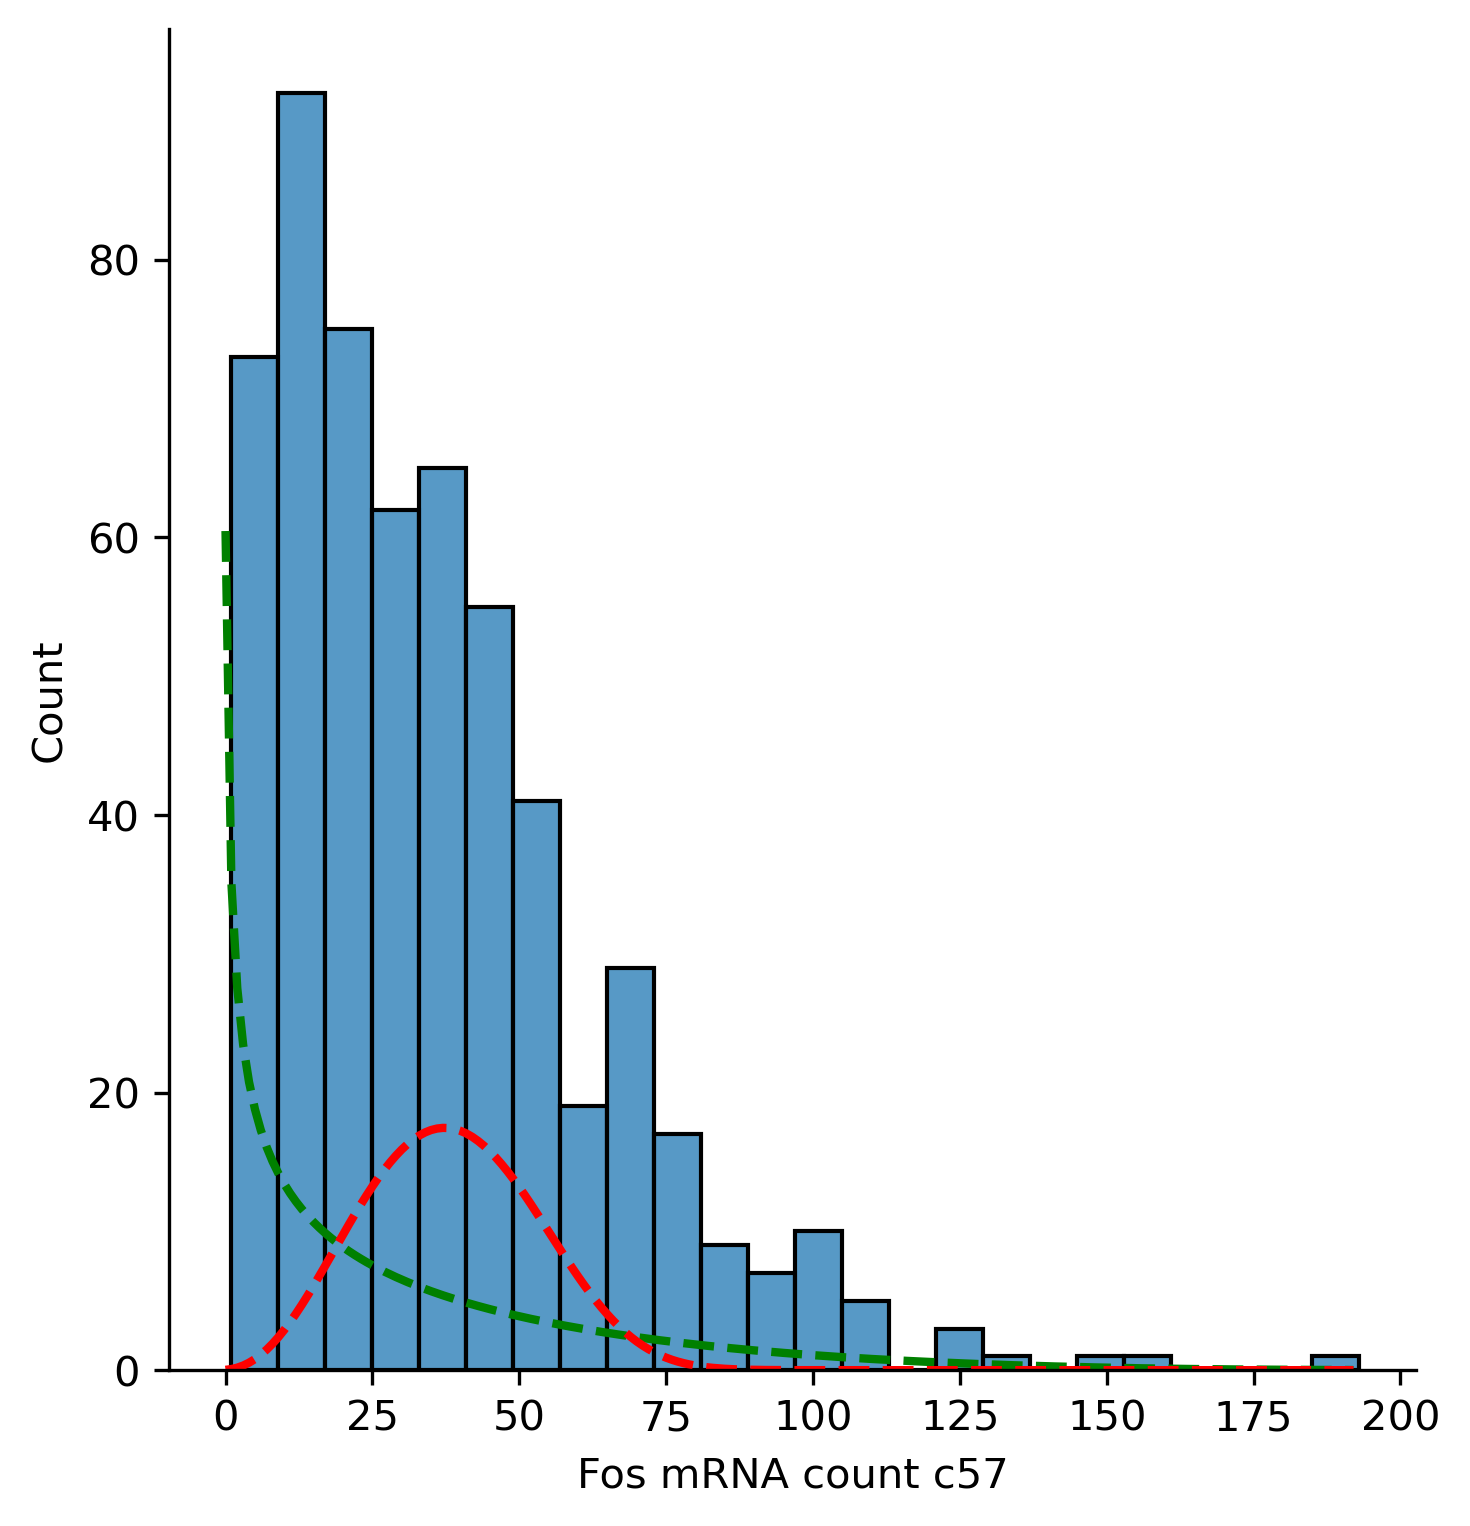

In [15]:
# Fos c57

allele= 'c57'
gene_name = "Fos"
adata = ad.read("./data/mus_musculus_preprocessed_all_params.h5ad")
# c57 = pd.read_csv('./../test/data/arme/umiSplit_c57.qc.csv', index_col=0)
c57 = adata.to_df(layer='allele_c57').transpose()
c57.index = adata.var.Accession

index_gene = adata.var_names.tolist().index(gene_name)
gene_id = adata.var['Accession'][index_gene]

################
# df_param_ctm = pd.read_csv("./../test/data/arme/umiSplit_c57.qc.maxl.ci.wfilt1.csv",
#                       header=None,
#                       index_col=0)
# extract kon, koff, ksyn for Fos
cells=682 # number of cells

tot_kon,tot_koff, tot_ksyn = tot_kon,tot_koff, tot_ksyn = adata.var.loc[gene_name]['c57_kon'], adata.var.loc[gene_name]['c57_koff'], adata.var.loc[gene_name]['c57_ksyn']
tot_koff

################
gene_values = np.array(c57.loc[gene_id])
gene_values = gene_values[gene_values>0]

df_GTM = npy2df(input_file="./data/plot_gtm/gene_Fos_c57.npy")
BFandBS(df_GTM)
index_param = best_parameters(df_GTM, test = gene_values)
tot_kon_gtm = df_GTM['ron'][index_param]
tot_koff_gtm = df_GTM['roff'][index_param]
tot_ksyn_gtm = df_GTM['mu'][index_param]

index_gene = adata.var_names.tolist().index(gene_name)
# gene_values = c57.loc[gene_id].tolist()



sns.displot(gene_values)
plt.plot(cells*dBP(np.arange(max(gene_values)), tot_kon, tot_koff, tot_ksyn),'g--',linewidth=2)
plt.plot(cells*dBP(np.arange(max(gene_values)), tot_kon_gtm, tot_koff_gtm, tot_ksyn_gtm),'r--',linewidth=2)
plt.xlabel("".join([gene_name, " mRNA count ", allele]))



plt.show()

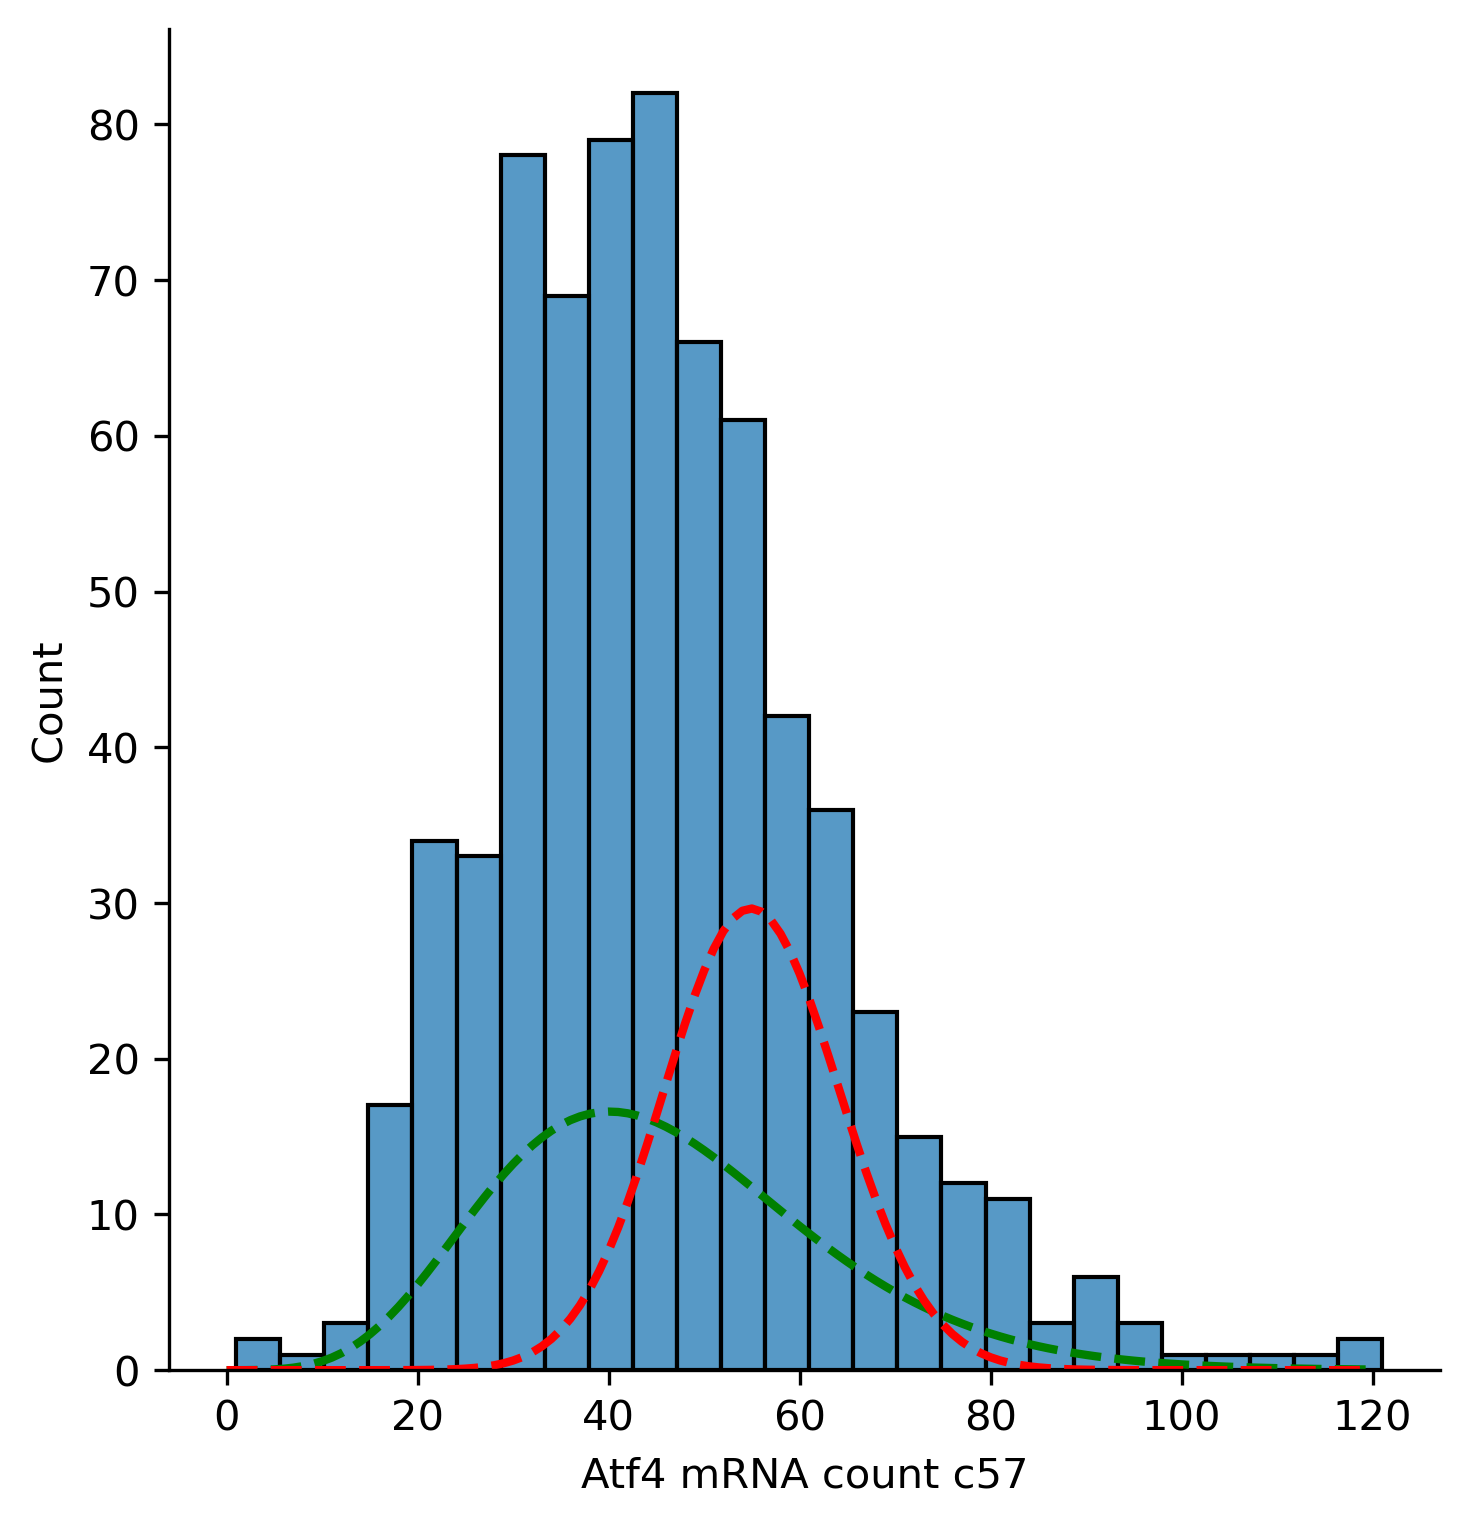

In [16]:
# All in one : 
allele= 'c57'
gene_name = "Atf4"
adata = ad.read("./data/mus_musculus_preprocessed_all_params.h5ad")
# c57 = pd.read_csv('./../test/data/arme/umiSplit_c57.qc.csv', index_col=0)
c57 = adata.to_df(layer='allele_c57').transpose()
c57.index = adata.var.Accession

index_gene = adata.var_names.tolist().index(gene_name)
gene_id = adata.var['Accession'][index_gene]

# ################
# df_param_ctm = pd.read_csv("./../test/data/arme/umiSplit_c57.qc.maxl.ci.wfilt1.csv",
#                       header=None,
#                       index_col=0)
# extract kon, koff, ksyn for Fos
cells=682 # number of cells

tot_kon,tot_koff, tot_ksyn = adata.var.loc[gene_name]['c57_kon'], adata.var.loc[gene_name]['c57_koff'], adata.var.loc[gene_name]['c57_ksyn']
tot_koff

################

gene_values = np.array(c57.loc[gene_id])
gene_values = gene_values[gene_values>0]

df_GTM = npy2df(input_file="./data/plot_gtm/gene_Atf4_c57.npy")
BFandBS(df_GTM)
index_param = best_parameters(df_GTM, test = gene_values)
tot_kon_gtm = df_GTM['ron'][index_param]
tot_koff_gtm = df_GTM['roff'][index_param]
tot_ksyn_gtm = df_GTM['mu'][index_param]

index_gene = adata.var_names.tolist().index(gene_name)
# gene_values = c57.loc[gene_id].tolist()



sns.displot(gene_values)
plt.plot(cells*dBP(np.arange(max(gene_values)), tot_kon, tot_koff, tot_ksyn),'g--',linewidth=2)
plt.plot(cells*dBP(np.arange(max(gene_values)), tot_kon_gtm, tot_koff_gtm, tot_ksyn_gtm),'r--',linewidth=2)
plt.xlabel("".join([gene_name, " mRNA count ", allele]))



plt.show()

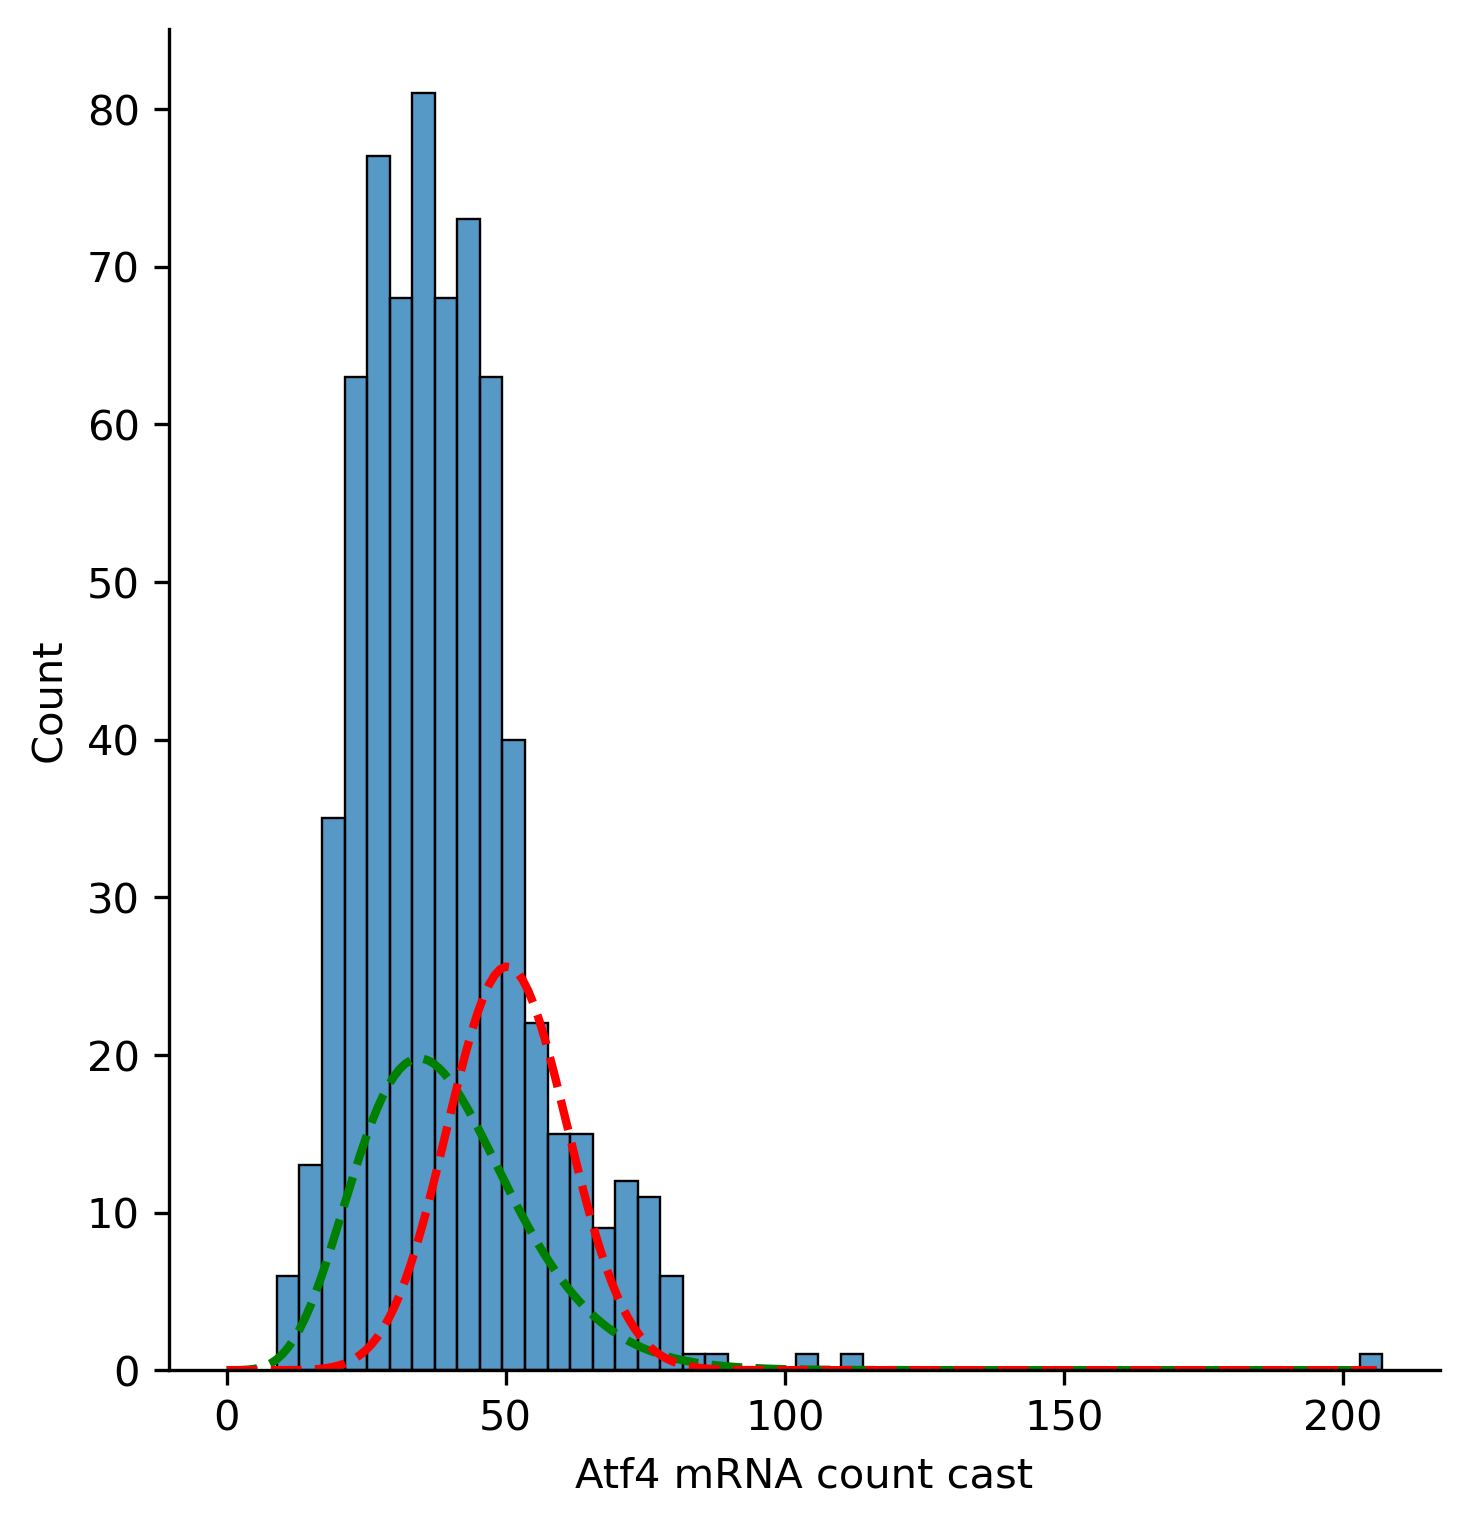

In [17]:
# All in one : 
allele= 'cast'
gene_name = "Atf4"
adata = ad.read("./data/mus_musculus_preprocessed_all_params.h5ad")
# c57 = pd.read_csv('./../test/data/arme/umiSplit_cast.qc.csv', index_col=0)
cast = adata.to_df(layer='allele_cast').transpose()
cast.index = adata.var.Accession

index_gene = adata.var_names.tolist().index(gene_name)
gene_id = adata.var['Accession'][index_gene]

################
# df_param_ctm = pd.read_csv("../test/data/arme/umiSplit_cast.qc.maxl.ci.wfilt1.csv",
#                       header=None,
#                       index_col=0)
# extract kon, koff, ksyn for Fos
cells=682 # number of cells

tot_kon,tot_koff, tot_ksyn = tot_kon,tot_koff, tot_ksyn = adata.var.loc[gene_name]['cast_kon'], adata.var.loc[gene_name]['cast_koff'], adata.var.loc[gene_name]['cast_ksyn']
# tot_kon,tot_koff, tot_ksyn = df_param_ctm.loc[gene_id][:3]

tot_koff

################
gene_values = np.array(cast.loc[gene_id])
gene_values = gene_values[gene_values>0]

df_GTM = npy2df(input_file="./data/plot_gtm/gene_Atf4_cast.npy")
BFandBS(df_GTM)
index_param = best_parameters(df_GTM, test = gene_values)
tot_kon_gtm = df_GTM['ron'][index_param]
tot_koff_gtm = df_GTM['roff'][index_param]
tot_ksyn_gtm = df_GTM['mu'][index_param]


index_gene = adata.var_names.tolist().index(gene_name)
# gene_values = cast.loc[gene_id].tolist()



sns.displot(gene_values)
plt.plot(cells*dBP(np.arange(max(gene_values)), tot_kon, tot_koff, tot_ksyn),'g--',linewidth=2)
plt.plot(cells*dBP(np.arange(max(gene_values)), tot_kon_gtm, tot_koff_gtm, tot_ksyn_gtm),'r--',linewidth=2)
plt.xlabel("".join([gene_name, " mRNA count ", allele]))



plt.show()

In [18]:
cast

,GCTTAGAGAAGACC,GCTTAGGTAAGTGG,GCTTAGTCCGTGTT,GTTGGAGTCTATTA,GTTGGAGAAGGCGT,GGATTCAGGTAGTG,ATGCCGGATGTCCT,ACGGTCGTTGTCTG,ACGAGTGCGATGAT,GCTTAGTACGACAC,...,GCGGTTTTGACCTA,CACTGTGACGTCCA,GCGGTTGTCAAGAC,GGATCACGGTGCTT,GCGGTTGTACAACG,GCGGTTAATCACGA,GCGGTTCTTCATCC,GCGGTTCATGAGTA,GCGGTTAACCAGAG,GCGGTTCACCGTCT
Accession,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000033845,0.0,0.0,0.0,5.0,0.0,0.0,0.0,1.0,0.0,NaN,...,0.0,NaN,0.0,NaN,0.0,1.0,2.0,0.0,0.0,3.0
ENSMUSG00000090031,11.0,3.0,NaN,0.0,2.0,0.0,3.0,1.0,2.0,1.0,...,4.0,1.0,1.0,5.0,0.0,0.0,4.0,6.0,1.0,2.0
ENSMUSG00000025917,7.0,0.0,NaN,12.0,0.0,10.0,NaN,5.0,13.0,17.0,...,11.0,4.0,2.0,20.0,7.0,0.0,5.0,6.0,NaN,0.0
ENSMUSG00000067851,1.0,7.0,NaN,0.0,NaN,0.0,0.0,2.0,3.0,5.0,...,5.0,2.0,3.0,NaN,5.0,0.0,8.0,7.0,0.0,0.0
ENSMUSG00000025935,14.0,3.0,8.0,6.0,18.0,7.0,19.0,16.0,23.0,21.0,...,3.0,6.0,5.0,6.0,5.0,1.0,8.0,5.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000025785,0.0,13.0,17.0,12.0,62.0,0.0,10.0,25.0,4.0,2.0,...,4.0,0.0,5.0,5.0,1.0,5.0,0.0,0.0,0.0,0.0
ENSMUSG00000035202,0.0,NaN,NaN,2.0,2.0,NaN,NaN,1.0,2.0,NaN,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
ENSMUSG00000025240,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,5.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0
